In [ ]:
# OpenAI GYM framework를 이용해서 Environment를 생성하고 사용
# pip install gym
import gym

# Environment 생성
env = gym.make('CartPole-v1')

# 환경을 초기화
# 초기화의 리턴은 시작 state
state = env.reset()

# 에피소드의 개수를 지정 (에피소드 : 학습의 한번 진행 = epoch)
num_of_episodes = 1000


for i in range(num_of_episodes):
    # 화면 출력
    env.render()
    
    # 환경(environment)에서 할 수 있는 행동들(action) 중 랜덤으로 꺼내온다.
    # 우리의 알고리즘으로 변경해야 하는 부분
    action = env.action_space.sample()
    
    # 만들어진 환경에 대해서 action 수행
    # step : 해당 action을 실행시키는 메서드 -> action을 실행한 상태(state), 보상(reward), 완료(done), 부가적인 정보(info) 리턴
    # reward : 마지막 결과를 쟁취했을 때만 있다. (나머지는 0)
    # done : reward 에 도착 or 잘못된 종료 일 때 True / 나머지는 False -> 게임을 계속 진행될지의 정보
    # info : 부가적인 정보. 크게 중요하진 않음
    state, reward, done, info = env.step(action)
    
    if done:
        state = env.reset()

env.close()

In [ ]:
# key 입력 문제로 인하여 jupyter notebook에서 정상적으로 실행 불가
# cmd에서 실행
# -*- coding:utf-8 -*-

import gym

# key 입력을 받기 위해 가장 쉽게 사용할 수 있는 package
import readchar

# 호수의 크기, 바람부는지의 여부 등의 설정
from gym.envs.registration import register


# MACRO 정의 
# key 입력 -> 0: 왼쪽 / 1 : 아래쪽 / 2: 오른쪽 / 3: 위쪽 (왼쪽부터 반시계 방향)으로 맵핑
# 액션으로 전달될 숫자
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

# Key Mapping (unicode 입력을 숫자로)
arrow_key = {
    '\x1b[A': UP,
    '\x1b[B': DOWN,
    '\x1b[C': RIGHT,
    '\x1b[D': LEFT
}

# FrozenLake 설정 등록
# v3 : 바람 없음 / v0 : 바람 있음
# kwargs 옵션값 : size, 미끌어지다(바람분다)
register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False}
)

# 환경 생성 (Environment)
env = gym.make('FrozenLake-v3')

# 환경 초기화 작업 진행 (action을 수행하기 전 초기화)
env.reset()

# 현재 state 출력
env.render()

# 반복적으로 key를 받아서 움직이기
while True:
    key = readchar.readkey()
    # 화살표 키가 아닌 다른 키를 입력한 경우
    if key not in arrow_key.keys():
        print(key, ': 잘못된 키를 입력하여 종료합니다...')
        break

    # action을 결정 (environment에 들어갈 값)
    # 입력된 키값에 맞는 숫자 -> 나중에는 자동으로 찾을 수 있도록 계산해야 함
    action = arrow_key[key]

    # state : 숫자
    # reward : G에 도착하면 1 or 0
    # done : True or False
    state, reward, done, info = env.step(action)
    env.render()
    print('state: {}, action: {}, reward: {}, done: {}'.format(state, action, reward, done))
    
    if done:
        print('받은 reward: {}'.format(reward))
        break


0.835
최종 Q table
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]


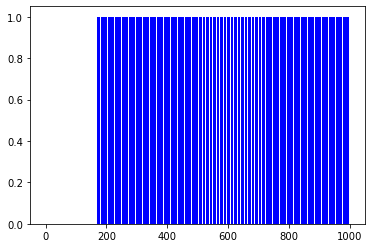

In [2]:
# -*- coding:utf-8 -*-

import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random


# 입력 vector가 [0 0 1 1] -> 2 or 3이 랜덤으로 리턴되는 함수
def random_argmax(vector):
    # amx() : 최대값 리턴
    m = np.amax(vector)
    # broadcasting -> [1 1 1 1] == [0 0 1 1] => [False, False, True, True]
    tmp = (m == vector)
    # nonzero() : 입력으로 들어온 요소 중 0이 아닌 요소의 index 반환 [2 3]
    result = np.nonzero(tmp)
    
    # 2와 3 중 random으로 선택
    return random.choice(result[0])


# FrozenLake 설정 등록
register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False}
)

# Environment 생성
env = gym.make('FrozenLake-v3')

# Q table 생성 및 0으로 초기화
# env.observation_space.n : 현재 env의 총 state 개수 = 16
# env.action_space.n : state에서 수행할 수 있는 action의 개수 = 4
Q = np.zeros([env.observation_space.n,env.action_space.n])

# episode의 개수 지정
num_of_episodes = 1000

# 각 episode별 total reward를 가지는 리스트를 하나 생성
# 정확도 확인용 -> 길을 찾으면 1, 아니면 0이 저장
reward_list = []

# episode 만큼 반복 처리
for i in range(num_of_episodes):
    
    # 환경 초기화 -> 초기화 한 state의 값 : 0
    state = env.reset()
    # reward의 총 합 (최대값 1) -> reward_list에 append할 값
    reward_all = 0
    done = False

    while not done:
        # action 정의
        # 1차원 numpy vector가 arg로 전달되면, 그 중 최대값을 찾는데, 만일 값이 같으면 랜덤으로 선택 -> index값 (action) 리턴
        # random_argmax() = algorithm. policy <- 우리가 작성해줘야 하는 것
        action = random_argmax(Q[state, :])
        
        # 환경에 적용을 시켜서 새로운 상태로 이동
        # info를 _로 쓴 이유 : 우리가 지금 안쓰고 있어서 버림
        new_state, reward, done, _ = env.step(action)
        
        # Q table update <- 우리의 목적
        # 현재상태의 action의 값 = 결과값 + 다음 상태의 action값중 최대값
        Q[state, action] = reward + np.max(Q[new_state, :])
        
        # 가장 마지막에 Goal에 들어가는 순간 1로 변할 뿐, 나머지 값은 모두 0
        reward_all += reward
        
        # 상태 변경 (action을 수행한 후의 state)
        state = new_state
    
    # while이 종료 = hole or goal에 당도했음
    # 최종 결과값 저장
    reward_list.append(reward_all)

print(sum(reward_list) / num_of_episodes)
print('최종 Q table')
print(Q)
plt.bar(range(len(reward_list)), reward_list, color='blue')
plt.show()